In [1]:
# Base utilities
import os
# Data Mining
import math
import random
random_state = 42
random.seed(random_state)
seed=random_state
import numpy as np 
import pandas as pd
import geopandas as gpd
import osmnx as ox
import pandana as pdn
import pickle as pkl
import shap


# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

# Learning
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# Models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Directories (Si no existen se crean)
for d in ["data", "logs", "models", "networks"]:
    if not os.path.isdir(d):
        os.mkdir(d)

In [ ]:
trips = pd.read_csv(f"data/Guadalajara_encoded_SEMS + NO SEMS_OK.csv",index_col=0)
trips = trips.drop(columns=['Longitud','Latitud','Latitud_centro','Longitud_centro','Centro específico','Tiempo origen-destino'])


# Renombrar las columnas en español a inglés
nuevos_nombres = {
    'NIVEL': 'Level',
    'CICLO': 'Cycle',
    'Centro': 'Center',
    'Promedio': 'Average',
    'SEXO': 'Gender',
    'EDAD': 'Age',
    'MUNICIPIO': 'Municipality',
    'Situacion conyugal': 'Marital status',
    'HIJOS': 'Children',
    'Personas en la vivienda': 'People in household',
    'Automoviles o camionetas en el hogar incluyendo cabina o caja': 'Cars/Vans in household',
    'Ingreso trimestral de todos los miembros del hogar': 'Quarterly family income',
    'Material del piso de la casa': 'Floor material of the house',
    'Agua entubada en la casa': 'Piped water in the house',
    'Luz electrica en la casa': 'Electric light in the house',
    'Primer integrante de la familia en asistir a la universidad': 'First to attend university',
    'drive_weight': 'Drive time',
    'walk_weight': 'Walk time',
    'transit_weight': 'Transit time'
}

trips.rename(columns=nuevos_nombres, inplace=True)




print(trips.head().columns)

In [ ]:
trips_shuffled = trips.sample(frac=1).reset_index(drop=True)


trips = trips.drop(trips[trips['Modo transporte'] == 'Public Transportation'].sample(38000).index)


# # Contar cuántas filas contienen 'Public Transportation'
# count_public_trans = trips[trips['Modo transporte'] == 'Private auto'].shape[0]

# # Definir la cantidad máxima de filas a eliminar (X o el número total si es menor)
# max_rows_to_remove = min(0, count_public_trans)

# # Filtrar y eliminar hasta X filas que contienen 'Public Transportation'
# trips = pd.concat([
#     trips[trips['Modo transporte'] != 'Private auto'],
#     trips[trips['Modo transporte'] == 'Private auto'].sample(frac=1).head(count_public_trans - max_rows_to_remove)
# ], ignore_index=True)


# Reiniciar los índices
trips.reset_index(drop=True, inplace=True)

for p in [f"{label}: {trips[trips['Modo transporte'] == label].shape[0]}" for label in trips['Modo transporte'].unique()]:
    print(p)
print(f"Total: {trips.shape[0]}")

trips = trips.sample(frac=1).reset_index(drop=True)


In [4]:
#Contar los valores vacíos de cada columna
NaN_mask = trips.apply(lambda col: col.astype(str).str.contains(r"\\N"))
trips = trips.where(~NaN_mask,None)
NaN_mask.sum()
"-" 

'-'

# Model Training and Evaluation

## Train-Test Split

In [5]:
X = np.array(trips.drop(columns="Modo transporte"))
y = np.array( trips["Modo transporte"] )
row_number = np.where(np.isnan(X))[0]
X = np.delete(X,row_number,axis=0)
y = np.delete(y,row_number,axis=0)


In [6]:
print(X.shape)
print(y.shape)

(34042, 19)
(34042,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

## Model Training/Evaluation Framework

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import pickle as pkl
import os

models = {}

def train_evaluate(model, X=X, y=y, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, k=10, cross_validation=True):
    model_name = type(model).__name__

    if cross_validation:
        print(model_name, "\n")
        print(f"{k}-FOLD CV\n")
        # k fold cross validation
        cv_scores = cross_val_score(model, X, y, cv=k, n_jobs=-1)

        # Scores on k-fold CV
        for i, score in zip(range(1, k+1), cv_scores):
            print(f"Round {i} score: {score*100}")
        print("")

        ax = sns.barplot(x=np.arange(1, 11), y=np.array(cv_scores*100))

        

        # Establecer tamaño de letra y fuente
        plt.rcParams.update({'font.size': 9, 'font.family': 'Times New Roman'})


        ax.set(xlabel='Round', ylabel='Accuracy (%)')
        #title=f"{k}-fold CV Accuracy plot"
        plt.show()

        # scores avg on k-fold CV
        print(f"Score avg on {k}-fold CV: {cv_scores.mean()}\n")

    # Final Model
    print("\nFinal Model\n")
    # Model Training
    model = model.fit(X_train, y_train)
    print("Accuracy: ", model.score(X_test, y_test), "\n")
    # Prediction and Report
    y_pred = model.predict(X_test)
    print("Classification Report\n")
    print(metrics.classification_report(y_test, y_pred), "\n")

    print("Confusion Matrix\n")
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    # Obtener los nombres de las clases
    class_names = np.unique(y)
    
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap="Reds", vmin=0, vmax=1)
    
    # Establecer los nombres de las clases como etiquetas de los ejes
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names, ha='center')
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names, va='center')
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()
    
    models[model_name] = model

    # pickle
    with open(os.path.join("models", f'{model_name}.pkl'), 'wb') as file:
        pkl.dump(model, file)


## Model Definition and Evaluation

## Random Forest

RandomForestClassifier 

10-FOLD CV

Round 1 score: 74.56681350954479
Round 2 score: 74.47870778267254
Round 3 score: 75.67567567567568
Round 4 score: 75.3231492361927
Round 5 score: 76.41010575793185
Round 6 score: 73.38425381903643
Round 7 score: 75.14688601645123
Round 8 score: 75.4406580493537
Round 9 score: 74.82373678025851
Round 10 score: 74.85311398354877



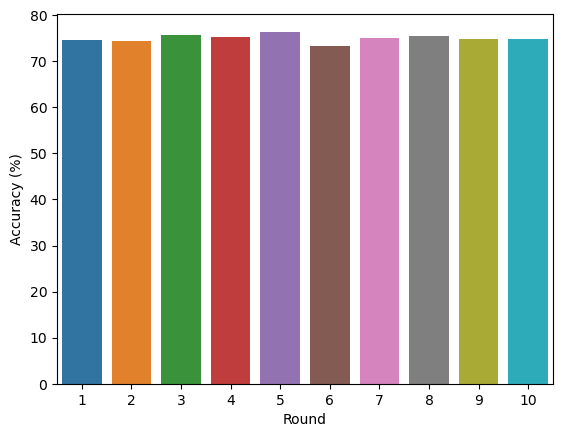

Score avg on 10-fold CV: 0.7501031006106662


Final Model

Accuracy:  0.7494369920689318 

Classification Report

                       precision    recall  f1-score   support

         Private auto       0.74      0.74      0.74      3258
Public Transportation       0.78      0.74      0.76      5103
                 Walk       0.69      0.79      0.74      1852

             accuracy                           0.75     10213
            macro avg       0.74      0.76      0.75     10213
         weighted avg       0.75      0.75      0.75     10213
 

Confusion Matrix



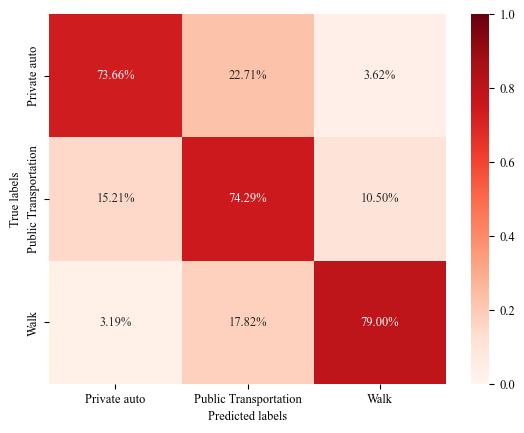

In [9]:
rf = RandomForestClassifier(n_estimators=20,random_state=random_state)
train_evaluate(rf)

Elapsed time to compute the importances: 0.018 seconds
Suma de los valores ploteados : 0.9999999999999999


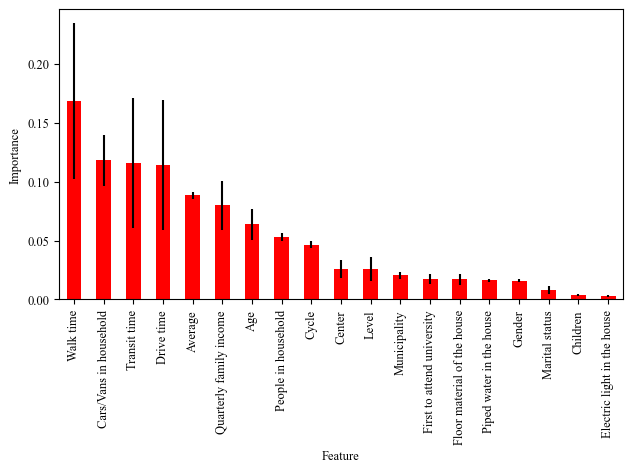

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 9

start_time = time.time()
importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=trips.drop(columns=['Modo transporte']).columns)

# Ordenar las importancias de las características de manera descendente
forest_importances_sorted = forest_importances.sort_values(ascending=False)

# Convertir std a una serie de pandas con los índices adecuados
std_series = pd.Series(std, index=forest_importances.index)

fig, ax = plt.subplots()
forest_importances_sorted.plot.bar(yerr=std_series[forest_importances_sorted.index], ax=ax, color='red', capsize=0)  # Eliminar las barras negras
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.tick_params(axis='x', rotation=90)  # Rotar etiquetas del eje x 45 grados
fig.tight_layout()

# Sumar todos los números ploteados en el gráfico
suma_valores = forest_importances_sorted.sum()
print(f"Suma de los valores ploteados : {suma_valores}")

plt.show()
